## Physics Informed Neural Networks

Here we are combine neural network and physical equations in the loss function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic data for the physical experiment

# Here experiment of a person throwing a ball from the top of a some bench, we want to trace/predict the parabolic path of the ball

# Physics Parameters
g = 9.8 # Acceleration due to gravity
h0 = 1.0 # Intial Height
v0 = 10.0 # Intial Velocity

# True analytical solution h(t) = h0 + v0*t - 0.5**g*t^2
def true_solution(t):
  return h0 + v0*t - 0.5*g*(t**2)

# Generate time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate data points with noise
np.random.seed(42)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to Pytorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1,1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1,1)

In [3]:
# Define a FF neural network
class PINN(nn.Module):
  def __init__(self, n_hidden=20):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1, n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden, n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden, 1)
    )
  def forward(self, t):
    return self.net(t)

# Instatiate the model
model = PINN(n_hidden=20)

In [4]:
# Automatic Differentiator
def derivative(y,x):
  return torch.autograd.grad(
      y, x,
      grad_outputs=torch.ones_like(y),
      create_graph=True
  )[0]

In [5]:
# Physics Loss
def physics_loss(model, t):
  t.requires_grad_(True)
  h_pred = model(t)
  dh_dt_pred = derivative(h_pred, t)
  dh_dt_true = v0 - g*t

  loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
  return loss_ode

# Initial Condition Loss
def initial_condition_loss(model):
  # At t=0
  t0 = torch.zeros(1,1, dtype=torch.float32, requires_grad=False)
  h0_pred = model(t0)
  return torch.mean((h0_pred - h0)**2)

# Data Losss
def data_loss(model, t_data, h_data):
  h_pred = model(t_data)
  return torch.mean((h_pred - h_data)**2)

In [6]:
# Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Weighting the loss terms
lambda_data = 1.0
lambda_ode = 1.0
lambda_ic = 1.0 # Initial Condition

# For logging
num_epochs = 4000
print_every = 200

In [7]:
# Training Loop
model.train()
for epoch in range(num_epochs):
  optimizer.zero_grad()

  # Compute Loss
  l_data = data_loss(model, t_data_tensor, h_data_tensor)
  l_ode = physics_loss(model, t_data_tensor)
  l_ic = initial_condition_loss(model)

  # Combined Loss
  loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

  # Backward Pass
  loss.backward()
  optimizer.step()

  # Print losses
  if (epoch+1) % print_every == 0:
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {loss.item():.6f}, Data Loss: {l_data.item():.6f}, ODE Loss: {l_ode.item():.6f}, IC Loss: {l_ic.item():.6f}")

Epoch 200/4000, Total Loss: 0.255344, Data Loss: 0.238544, ODE Loss: 0.013748, IC Loss: 0.003052
Epoch 400/4000, Total Loss: 0.249618, Data Loss: 0.239348, ODE Loss: 0.007948, IC Loss: 0.002322
Epoch 600/4000, Total Loss: 0.244210, Data Loss: 0.236112, ODE Loss: 0.005872, IC Loss: 0.002226
Epoch 800/4000, Total Loss: 0.238147, Data Loss: 0.231778, ODE Loss: 0.004755, IC Loss: 0.001614
Epoch 1000/4000, Total Loss: 0.228512, Data Loss: 0.223297, ODE Loss: 0.004065, IC Loss: 0.001150
Epoch 1200/4000, Total Loss: 0.220787, Data Loss: 0.215418, ODE Loss: 0.004365, IC Loss: 0.001004
Epoch 1400/4000, Total Loss: 0.219254, Data Loss: 0.213482, ODE Loss: 0.004764, IC Loss: 0.001009
Epoch 1600/4000, Total Loss: 0.218721, Data Loss: 0.212887, ODE Loss: 0.004820, IC Loss: 0.001014
Epoch 1800/4000, Total Loss: 0.218155, Data Loss: 0.212387, ODE Loss: 0.004753, IC Loss: 0.001015
Epoch 2000/4000, Total Loss: 0.217470, Data Loss: 0.211724, ODE Loss: 0.004734, IC Loss: 0.001012
Epoch 2200/4000, Total L

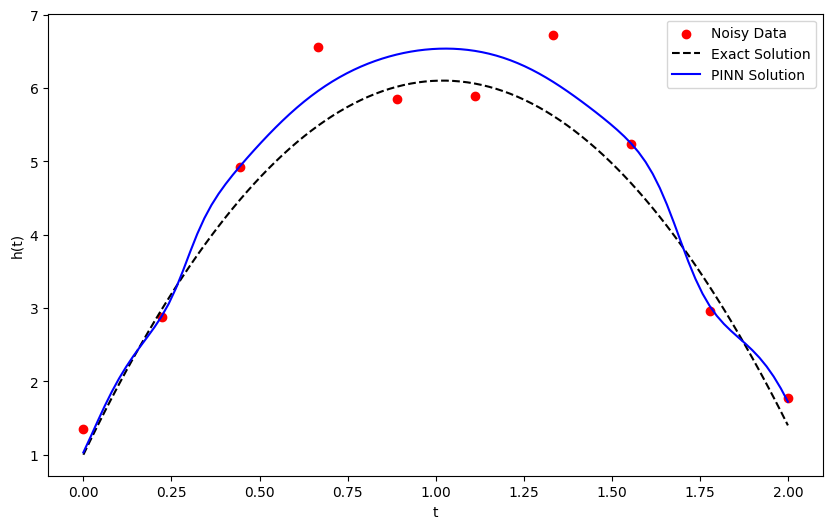

In [8]:
# Evaluate the trained model
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Solution')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.show()